In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import expit

In [2]:
def sigmoid_interpolation(y_values, x_original, x_interpolated):
    y_interpolated = np.zeros_like(x_interpolated)
    for i in range(1, len(y_values)):
        # Segment interpolation between each pair of points
        x_start, x_end = x_original[i-1], x_original[i]
        y_start, y_end = y_values[i-1], y_values[i]
        
        # Normalize to [0, 1] for the sigmoid function
        x_segment = x_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)]
        x_normalized = (x_segment - x_start) / (x_end - x_start)
        
        # Apply sigmoid for ease-in and ease-out
        sigmoid_segment = expit(12 * (x_normalized - 0.5))  # Steepness factor 12 for sharp transition
        y_segment = y_start + (y_end - y_start) * sigmoid_segment
        
        # Store the interpolated segment
        y_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)] = y_segment
    
    return y_interpolated

def linear_interpolation(y_values, x_original, x_interpolated):
    y_interpolated = np.zeros_like(x_interpolated)
    for i in range(1, len(y_values)):
        # Segment interpolation between each pair of points
        x_start, x_end = x_original[i-1], x_original[i]
        y_start, y_end = y_values[i-1], y_values[i]
        
        # Select the segment for interpolation
        x_segment = x_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)]
        
        # Linear interpolation
        y_segment = y_start + (y_end - y_start) * (x_segment - x_start) / (x_end - x_start)
        
        # Store the interpolated segment
        y_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)] = y_segment
    
    return y_interpolated

In [8]:
x = np.linspace(-3, 3, 21600)
control_values = np.exp(-x**2)

# Normalize to ensure values start at 0, peak at 1, and return to 0
df = pd.DataFrame({
    'control': control_values
})

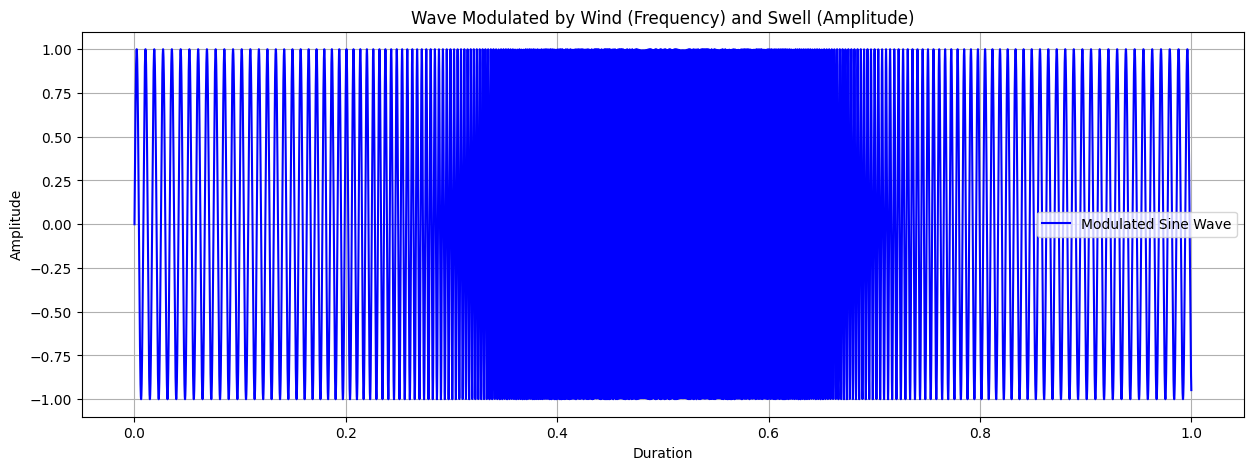

In [12]:
# Mapping function for frequency
def map_to_frequency(value, min_freq=0.1667*720, max_freq=1.1667*720):
    return min_freq + (max_freq - min_freq) * value

# Apply mapping to frequency and use swell as amplitude
frequencies = df['control'].apply(map_to_frequency).to_numpy()

x_interpolated = np.linspace(0, 1, 21600)

# Generate the sine wave with varying frequency
time_step = 1 / len(x_interpolated)  # Time step for each sample
sine_wave = np.zeros_like(x_interpolated)
phase = 0  # Initial phase

for i in range(1, len(x_interpolated)):
    # Increment the phase based on the current frequency
    phase += 2 * np.pi * frequencies[i] * time_step
    sine_wave[i] = np.sin(phase)

# Plotting the sine wave
plt.figure(figsize=(15, 5))
plt.plot(x_interpolated, sine_wave, color='b', label='Modulated Sine Wave')
plt.xlabel('Duration')
plt.ylabel('Amplitude')
plt.title('Wave Modulated by Wind (Frequency) and Swell (Amplitude)')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# Convert sine_wave to DataFrame
df_sine_wave = pd.DataFrame({'time': x_interpolated, 'sine_wave': sine_wave})
df_sine_wave.to_csv("../data/sine_03.csv",index= False)